# Multimodal Attribute Extraction Demo

In this notebook we will demonstrate the best performing multimodal attribute extraction model. We'll start by loading the neccessary modules.

(Note: The Python modules needed to run this notebook are listed in `requirements.txt`)

In [266]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.contrib.slim.python.slim.nets.vgg import vgg_16

from utils.image_processing import process_images
from utils.embedding import GloveEncoder
from utils.vocabulary import Vocabulary

%matplotlib inline

Next, we will need to download:

1. A model checkpoint.
2. The GloVe word embeddings, and attribute/value vocabularies used by the model.
3. Some data to test on.

These are provided at the following link: 

## Preprocessing

### Attributes and Values

Attributes and values need to be mapped to the same integer labels that were used during training. This can be done using the `Vocabulary` object included in the `utils` module.

In [25]:
attribute_vocab = Vocabulary()
attribute_vocab.load('data/attribute_vocab.txt')

value_vocab = Vocabulary()
value_vocab.load('data/value_vocab.txt')

The integer labels will be used to map attributes to $k$-dimensional vectors, and to lookup value ids predicted by the model later on.

### Text

We embed words using pretrained GloVe embeddings. Each word $w$ is replaced with a vector $v_w$ which is looked up from an embedding matrix. We've defined a `GloveEncoder` object in the `utils` module to make this easy. 

WARNING: This will consume a ton of memory while loading.

In [5]:
glove_encoder = GloveEncoder(vocab_filename='data/vocab.txt', vector_filename='data/vectors.txt')

(813545, 200)
Done loading glove


Test that the encoder is working by looking up the embeddings for some words.

In [8]:
glove_encoder.lookup('grey')

array([  3.82198329e-02,  -3.68442319e-03,   2.75032940e-02,
        -1.67245133e-02,   1.38510789e-02,  -1.16133013e-02,
         2.46747648e-01,  -4.30241533e-02,  -1.23287872e-03,
        -2.86306725e-02,   2.72331583e-02,   3.68270854e-03,
         2.45586978e-01,   3.77605508e-03,  -1.05368506e-02,
        -2.62497317e-02,  -2.21851457e-02,  -1.60856980e-02,
         3.21145127e-02,  -1.67966861e-02,  -4.76758966e-02,
        -2.67498195e-02,  -4.05374981e-02,   5.07105258e-02,
        -2.59573584e-03,   1.87191607e-03,  -1.83341836e-02,
         7.65194589e-03,   7.93941011e-03,  -2.67502778e-03,
         2.57580368e-02,   7.22207132e-04,  -2.61107575e-02,
         5.53192798e-03,  -2.55824355e-02,  -1.45761185e-02,
        -2.69936212e-02,   3.88281366e-02,  -6.73878778e-02,
         1.82382992e-02,   1.00171932e-02,   1.54837718e-01,
        -2.63041834e-02,  -4.25515113e-02,   3.07073081e-01,
         5.24196370e-02,  -2.11879394e-02,   8.32089294e-03,
        -1.13755246e-02,

### Image

The provided model uses the VGG-16 convoultional neural network to encode images, which requires a collection of preprocessing steps (e.g. pixel normalization, cropping, etc.) be applied to the image before it can be fed through the network. Luckily, a TensorFlow implementation of both the network and preprocessing steps are provided in [tf-slim](https://github.com/tensorflow/models/tree/master/research/slim). We've included the relevant scripts with this notebook.

Let's just quickly check that this works as intended.

In [210]:
# 1. Read a JPEG image as a string of bytes
with open('data/img/test.jpeg', 'rb') as f:
    encoded_image = f.read()
    
# 2. Create a placeholder tensor to feed the image into.
x = tf.placeholder(dtype=tf.string, shape=(None,))

# 3. Add the image processing operator to the computation graph.
processed = process_images(x, height=224, width=224, is_training=False)

# 4. Run.
with tf.Session() as sess:
    out = sess.run(processed, feed_dict={x: [encoded_image]})

Pay close attention to the dimension of this output:

In [211]:
print(out.shape)

(1, 224, 224, 3)


The image is 224 x 224 x 3, however there is an additional dimension in front which accounts for the fact that there could be multiple images for a single product (this is why the encoded image is wrapped in a list above). Hence the tensor for a single item has shape (n_images, height, width, n_channels). As a sanity check let's plot the output (rescaled for matplotlib).

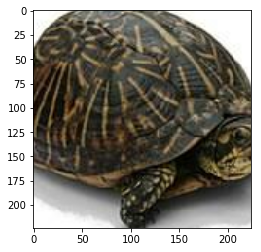

In [21]:
# Remove the n_image dimension
out = np.squeeze(out)

# Rescale - the axis argument deals with the different offsets for the different channels
out = (out - np.min(out, axis=(0,1)))/(np.max(out, axis=(0,1)) - np.min(out, axis=(0,1)))

# Plot
plt.imshow(out);

## Building the Model

Now that we can read the inputs, it's time to layout the model architecture.

### Configuration

The following hyperparameters are used by the model.

WARNING: Do not change these if you want to be able to restore the model from the included checkpoint.

In [99]:
# Image format
image_height = 224
image_width = 224

# Number of hidden units in the image/fc1 layer 
image_hidden_layer_size = 4096

# Vocab sizes.
attribute_vocab_size = 100 
value_vocab_size = 634     

# Embedding size.
embedding_size = 1024

# Convolution params.
window_size = 5
conv_features = 1024

### Model Code

#### Inputs
We start by creating placeholders for the following pieces of information:
- The bytestrings of item's images
- The glove vectors of the words in the item's description
- The attribute queries

In [317]:
tf.reset_default_graph()
g = tf.Graph()

In [318]:
# Create placeholders
with g.as_default():
    image_input = tf.placeholder(dtype=tf.string, shape=(None,)) # [n_images]
    description_input = tf.placeholder(dtype=tf.float32, shape=(None, 200)) # [description_length, glove_embedding_size]
    attribute_queries = tf.placeholder(dtype=tf.int32, shape=(None,)) # [n_queries]

#### Attribute Embeddings

The following code defines the attribute embedding matrix and an operation to lookup the embeddings for the queried attributes. The `tf.variable_scope` context essentially creates a namespace for the variables. This can prevent issues when reusing variable names, and also looks nice in TensorBoard. The `tf.device(/cpu:0)` tells TensorFlow to keep the embedding matrix on the CPU instead of GPU, which can prevent memory issues when there are a large amount of attributes in the vocabulary.

In [319]:
with g.as_default():
    with tf.variable_scope('attribute_embeddings'), tf.device('/cpu:0'):
        # The embedding matrix
        attribute_embedding_matrix = tf.get_variable(
            shape=[attribute_vocab_size, embedding_size],    
            name='attribute_embedding_matrix')
        # Lookup embeddings for queried attributes
        attribute_embeddings = tf.nn.embedding_lookup(
            attribute_embedding_matrix,
            attribute_queries,             
            name='attribute_embeddings')    

#### Value Embeddings

Same as above - but we only need the embedding matrix (since there is no value to lookup).

In [320]:
with g.as_default():
    with tf.variable_scope('value_embeddings'), tf.device('/cpu:0'):
        value_embedding_matrix = tf.get_variable(
            shape=[value_vocab_size, embedding_size],
            name='value_embedding_matrix')

#### Image Embedding via VGG-16


Look how simple this is... the `vgg_16` function sets up the whole VGG-16 network for us. `end_points` is just a dictionary containing all of the tensors in the network. We take the output of the *fc7* layer, feed it through some hidden layers, pool over the results, and we're done.

In [321]:
with g.as_default():

    # Apply image processing operation
    processed_images = process_images(image_input, height=image_height, width=image_width, is_training=False)

    # VGG-16
    _, end_points = vgg_16(processed_images, is_training=False)
    vgg_out = end_points['vgg_16/fc7']

    # Flatten
    vgg_out = tf.reshape(vgg_out, shape=(-1, 4096))

    # FC1
    with tf.variable_scope('image/fc1') as scope:
        fc1 = tf.contrib.layers.fully_connected(
            inputs=vgg_out,   
            num_outputs=image_hidden_layer_size,               
            scope=scope)

    # FC2
    with tf.variable_scope('image/fc2') as scope:
        fc2 = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=embedding_size,
            scope=scope)

    # Max-pooling
    image_embeddings = tf.reduce_max(fc2, axis=0, keep_dims=True)

#### Description Embedding

Description embedding is done through convolution as well. The idea is to take the matrix of glove embeddings and treat it like an image. There are some strange operations that need to be applied to make this work - in particular we need to add fake 'batch' and 'num_channels' dimensions so that the tensor's shape is correct. In addition we perform max-pooling over time to get a single feature vector instead of a feature vector for each word. See [Kim 2014](https://arxiv.org/abs/1408.5882) for more details.

In [322]:
with g.as_default():

    _description_input = tf.expand_dims(description_input, 0) # Add 'batch' dim
    _description_input = tf.expand_dims(_description_input, 3) # Add 'num_channels' dim

    # Convolutional layer
    with tf.variable_scope('text/convolution'):
        # Convolution weights
        filters =  tf.get_variable(
            shape=[window_size, 200, 1, conv_features],
            name='filters')
        biases = tf.Variable(tf.zeros(shape=[conv_features]), name='biases')
        # Apply convolution
        conv = tf.nn.conv2d(
            _description_input,
            filters,
            strides=[1,1,1,1],
            padding='VALID',
            name='convolution')
        hidden = tf.nn.relu(tf.nn.bias_add(conv, biases),
                                 name="hidden")
        #Flatten
        hidden = tf.reshape(hidden, [-1, conv_features])

        # Pool over time
        pooled = tf.reduce_max(hidden, axis=0, keep_dims=True)

    # Fully connected layer
    with tf.variable_scope('text/fc1') as scope:
        description_embeddings = tf.contrib.layers.fully_connected(
            pooled,
            embedding_size,
            scope=scope)


####  Fusion via Concatenation 

As we showed in our results, using concatenation to fuse the embeddings was the most effective approach.

In [323]:
with g.as_default():

    # Need to 'tile' (e.g. duplicate) embeddings for each attribute.
    num_attributes = tf.shape(attribute_embeddings)[0]
    image_embeddings = tf.tile(image_embeddings, [num_attributes, 1])
    description_embeddings = tf.tile(description_embeddings, [num_attributes, 1])

    # Concat text and attributes -> fc
    with tf.variable_scope('text/fc2') as scope: # NOTE: Screwed up naming during training
        concat =  tf.concat([description_embeddings, attribute_embeddings], axis=1)
        desc_concat_out = tf.contrib.layers.fully_connected(concat, embedding_size, scope=scope)    

    # Concat image and attributes -> fc
    with tf.variable_scope('image/concat') as scope: # NOTE: Screwed up naming during training
        concat =  tf.concat([image_embeddings, attribute_embeddings], axis=1)
        image_concat_out = tf.contrib.layers.fully_connected(concat, embedding_size, scope=scope)

    # Final concat layer
    with tf.variable_scope('combine/concat') as scope:
        concat = tf.concat([image_concat_out, desc_concat_out], axis=1)
        predicted_embeddings = tf.contrib.layers.fully_connected(concat, embedding_size, scope=scope)

####  Prediction

To make a prediction we find the value embedding with the highest *cosine similarity*:

$$ g(x_1, x_2) = \frac{x_1 \cdot x_2}{|x_1| |x_2|}  $$

In [324]:
with g.as_default():
    # Compute norms
    predicted_norm = tf.norm(predicted_embeddings, axis=1, keep_dims=True)
    predicted_normalized = predicted_embeddings / predicted_norm

    value_norm = tf.norm(value_embedding_matrix, axis=1, keep_dims=True)
    value_normalized = value_embedding_matrix / value_norm

    # Compute dot product of normalized vectors
    similarity = tf.tensordot(
        predicted_normalized,
        value_normalized,
        axes=[[1], [1]])
    top_similarities, top_k = tf.nn.top_k(similarity, k=20)


#### Appendix: Max-Margin Loss

While the model defined above is missing much of the code needed to train it properly (e.g. a placeholder for training values, support for a batch size larger than 1, dropout layers, serialized data readers to increase speed), we include the basic sketch of the max-margin loss function to demonstrate how one would perform the negative sampling in TensorFlow.

Note: Do not run this cell - it is provided merely for illustration.

In [249]:
with g.as_default():
    # Obtain negative samples
    sample_ids, _, _ = tf.nn.fixed_unigram_candidate_sampler(
        true_classes=tf.cast(tf.expand_dims(true_value_ids, 1),
                             tf.int64),
        num_true=1,
        num_sampled=100, # Stupid hack - oversample and then reduce to correct size
        unique=False,
        range_max=value_vocab_size,
        unigrams=value_counts)
    sample_ids = tf.slice(sample_ids,
                          begin=(0,),
                          size=tf.shape(value_ids))
    
    # Lookup their embeddings
    sample_embeddings = tf.nn.embedding_lookup(
        value_embedding_matrix,
        sample_ids,
        name='sample_value_embeddings')

    # Measure true cosine similarities
    predicted_norm = tf.norm(predicted_embeddings, axis=1)

    true_norm = tf.norm(value_embeddings, axis=1)
    true_dot_products = dot_product(
        predicted_embeddings,
        value_embeddings)
    true_similarity = true_dot_products / (predicted_norm * true_norm)
    
    # Measure the sample cosine similarities
    sample_norm = tf.norm(sample_value_embeddings, axis=1)
    sample_dot_products = dot_product(
        predicted_embeddings,
        sample_value_embeddings)
    sample_similarity = sample_dot_products / (predicted_norm * sample_norm)

    # Combine into loss
    true_loss = tf.square(1 - true_similarity)
    sample_loss = tf.square(sample_similarity)
    loss = true_loss + sample_loss
    loss = self.pair_mask * loss

NameError: name 'true_value_ids' is not defined

## Demonstration

For demonstration we've included a small dataset of to test on. The following function generates training examples one at a time: 

In [338]:
from IPython.display import clear_output

def demo_generator(sample_file, image_dir):
    """Generates examples from demonstration file."""
    with open(sample_file, 'r') as f:
        data = json.load(f)
    for product in data:
        # Print contextual information
        clear_output()
        print('Title: ', product['title'])
        print('Description: ', product['text'])
        print()
        
        # Read image bytestrings
        image_input = []
        for image in product['images']:
            path = os.path.join(image_dir, image)
            # Show the image
            im = PIL.Image.open(path)
            plt.imshow(np.asarray(im))
            plt.show()
            with open(path, 'rb') as g:
                image_input.append(g.read())
        
        # Lookup word embeddings
        description_input = [glove_encoder.lookup(x) for x in product['tokens']]
        
        # Lookup attribute/value pairs
        for attribute, value in product['specs'].items():
            # Print contextual data
            print('\tAttribute: ', attribute)
            print('\tTrue Value: ', value)
            attribute_input = [attribute_vocab.word_to_id(attribute)]
            yield image_input, description_input, attribute_input

Note: To make this work for your product data in the wild you will need the Stanford tokenizer to tokenize the product descriptions (tokenization was performed ahead of time for the included dataset).

### Check out some examples

Title:  HP Pavilion 15-r126ne(Intel Core i7-4510U4th-Gen,15.6 Inch, 500GB, 4GB, 2GB nVidia Geforce, Windows 8.1, White)
Description:  Get the features you need and the reliability you expect with this value-packed HP Notebook.Are you a Gamer? or even some Graphic designer? You are in the right place and looking for the awesome product to fit your needs, with a great price. Enjoy rich, smooth web chats with the stunning HD display and easily take it on the road with a thin design combined with security features .



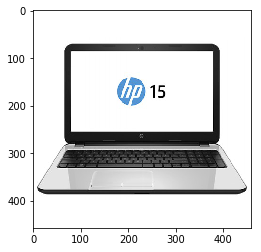

	Attribute:  aspect_ratio
	True Value:  16:9
Predicted Values:  ['16:9', '16:10', '4:3', 'Standard', '2005', '2007', 'Original (Unopened)', 'S', '2010', '2013', '3.5L V6', 'N/A', '2006', 'Large', 'Country', 'Small', 'Bulk', 'Action Figure', 'Medium', '10']

	Attribute:  colors
	True Value:  White
Predicted Values:  ['White', 'Clear', 'Silver', 'Natural', 'Multicolor', 'Green', 'Multi', 'Grey', 'Gold', 'Brown', 'Red', 'white', 'Blue', 'Beige', 'Pink', 'Bronze', 'Orange', 'Multi-Colored', 'Assorted', 'Navy']

	Attribute:  touchscreen
	True Value:  No
Predicted Values:  ['Yes', 'No', 'yes', 'no', 'Bluetooth 4.0', 'Report abuse', '4.0', '(0)', 'USB 2.0 (480 Mbit/sec)', 'FREE Shipping', 'Micro', 'Array', 'Limited Lifetime', 'Lifetime', 'Vehicle does NOT have an existing warranty', '12 Months', 'N/A', 'Limited Warranty', '12 months', 'No Additional Features']


KeyboardInterrupt: 

In [339]:
with g.as_default():
    saver = tf.train.Saver()
    with tf.Session(graph=g) as sess:
        saver.restore(sess, 'data/ckpt/model.ckpt')
        for img, desc, attr in demo_generator('data/sample.json', 'data/img'):
            preds = sess.run(top_k, feed_dict={image_input: img, 
                                               description_input: desc,
                                               attribute_queries: attr})
            preds = [value_vocab.id_to_word(x) for x in preds[0]]
            print('Predicted Values: ', preds)
            input()

In [340]:
sess.close()